<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/pedro/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fiona.supported_drivers

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/MyDrive/Capstone/Data'

east_gippsland.zip


In [ ]:
import geopandas as gpd

In [ ]:
fires_egl = gpd.read_file('/content/gdrive/MyDrive/Capstone/Data/east_gippsland.zip!ll_gda2020/filegdb/cma100/East Gippsland-1000/FIRE.gdb')
fires_egl.head()

,FIRETYPE,SEASON,FIRE_NO,NAME,START_DATE,START_DATE_INT,TREATMENT_TYPE,FIRE_SEVERITY,FIRE_COVER,FIREKEY,CREATE_DATE,UPDATE_DATE,AREA_HA,METHOD,METHOD_COMMENTS,ACCURACY,DSE_ID,CFA_ID,DISTRICT_ID,geometry
0,BUSHFIRE,2007,12,None,2006-12-01,20061201,FIRE,BURNT_3,0-9,W20079912,NaT,2020-12-30 16:28:53,1.240651,Satellite Image Interpretation - Automated,Intepreted from FIRE_SEV_WF data,HIGH,NaN,NaN,None,"MULTIPOLYGON (((146.82326 -37.32867, 146.82338..."
1,BUSHFIRE,2007,12,None,2006-12-01,20061201,FIRE,BURNT_2P,0-9,W20079912,NaT,2020-12-30 16:29:06,0.380197,Satellite Image Interpretation - Automated,Intepreted from FIRE_SEV_WF data,HIGH,NaN,NaN,None,"MULTIPOLYGON (((146.81885 -37.33146, 146.81897..."
2,BUSHFIRE,2007,12,None,2006-12-01,20061201,FIRE,BURNT_3,0-9,W20079912,NaT,2020-12-30 16:28:53,4.762495,Satellite Image Interpretation - Automated,Intepreted from FIRE_SEV_WF data,HIGH,NaN,NaN,None,"MULTIPOLYGON (((146.81716 -37.33064, 146.81716..."
3,BUSHFIRE,2007,12,None,2006-12-01,20061201,FIRE,BURNT_3,0-9,W20079912,NaT,2020-12-30 16:28:53,0.820428,Satellite Image Interpretation - Automated,Intepreted from FIRE_SEV_WF data,HIGH,NaN,NaN,None,"MULTIPOLYGON (((146.81998 -37.33263, 146.82009..."
4,BUSHFIRE,2007,12,None,2006-12-01,20061201,FIRE,BURNT_3,0-9,W20079912,NaT,2020-12-30 16:28:53,0.130068,Satellite Image Interpretation - Automated,Intepreted from FIRE_SEV_WF data,HIGH,NaN,NaN,None,"MULTIPOLYGON (((146.82426 -37.33778, 146.82426..."


<Axes: >

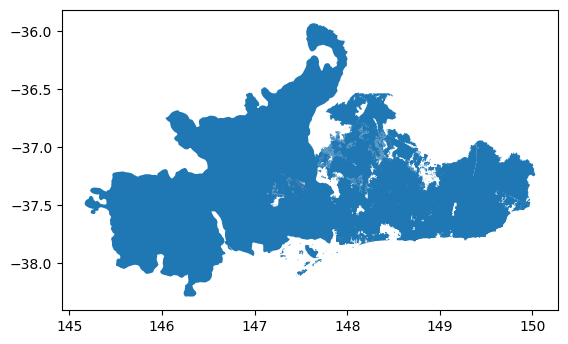

In [ ]:
fires_egl.plot()

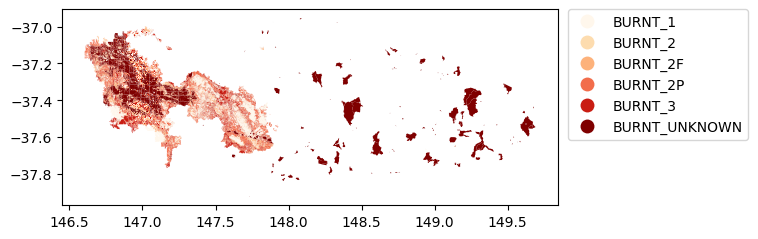

In [ ]:
season_07 = fires_egl[fires_egl['SEASON'] == 2007]


season_07.plot(column='FIRE_SEVERITY',
               legend=True,
               legend_kwds={'loc': 'upper left',
                            'bbox_to_anchor': (1.02, 1),
                            'borderaxespad': 0},
               cmap='OrRd');